In [3]:
# import packages and clean the text file
import glob
import re
import os
from collections import Counter
import numpy as np
from tqdm import tqdm
import sentencepiece as spm

if not os.path.exists('sentencepiece'):
    os.makedirs()

with open('e_coli_genome.txt','r') as f:
    e = f.read()
e = e.split()
e = ''.join([i for i in e if len(i)==10 and re.sub('[acgt]','',i)==''])
print('genome size:',len(e))

genome size: 4641650


In [4]:
# process file into chunks for tokenizer. 
# L is the length of chunks- the maximum is 4192.
# Should check if results depend on L

L=4192
e2 = '\n'.join([e[k:k+L] for k in np.arange(0,len(e),L)])

with open('e_coli_genome_processed.txt','w') as f:
    f.write(e2)

In [6]:
# Fit tokenizer to genome for different vocab lengths
Nmax = 79961
for N in np.arange(1000, Nmax, 1000):
    model_file = f'sentencepiece/ecoli_{N}.model'
    if not os.path.exists(model_file):
        spms = f'''--input=e_coli_genome_processed.txt 
--model_prefix=sentencepiece/ecoli_{N} 
--vocab_size={N}'''.replace('\n', '')

        spm.SentencePieceTrainer.train(spms)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=e_coli_genome_processed.txt --model_prefix=sentencepiece/ecoli_48000 --vocab_size=48000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: e_coli_genome_processed.txt
  input_format: 
  model_prefix: sentencepiece/ecoli_48000
  model_type: UNIGRAM
  vocab_size: 48000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_voca

In [8]:
import sentencepiece as spm

model_path = 'sentencepiece/ecoli_100.model'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"model file {model_path} doesnt exist")

# Load the SentencePiece model
sp = spm.SentencePieceProcessor()
sp.load(model_path)
print('raw sequence:')
print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

raw sequence:
agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat

tokenized sequence:
agc ttt tcatt ctgact gca acg ggcaat atg tctct gtgt ggatt aaaa aaagag tgt ctgata gca gct tct gaactg gttacc tgccg tgagt aaat

corresponding tokens:
25 23 700 964 58 16 168 29 580 649 367 98 566 73 482 58 47 77 258 767 299 818 109

# tokens in genome: 1017199


In [10]:
#vocab size: 8,000
sp = spm.SentencePieceProcessor(model_file='sentencepiece/ecoli_8800.model')

sp.load(model_path)

print('raw sequence:')
print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

raw sequence:
agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat

tokenized sequence:
agc ttt tcatt ctgact gca acg ggcaat atg tctct gtgt ggatt aaaa aaagag tgt ctgata gca gct tct gaactg gttacc tgccg tgagt aaat

corresponding tokens:
25 23 700 964 58 16 168 29 580 649 367 98 566 73 482 58 47 77 258 767 299 818 109

# tokens in genome: 1017199


In [11]:
#vocab size: 79,000
sp = spm.SentencePieceProcessor(model_file='sentencepiece/ecoli_79000.model')

print('raw sequence:')
print(e[:100])
print('\ntokenized sequence:')
print(' '.join(sp.encode_as_pieces(e[:100])[1:]))
print('\ncorresponding tokens:')
print(' '.join([str(i) for i in sp.encode(e[:100])[1:]]))
print()
print('# tokens in genome:',len(sp.encode_as_pieces(e)))

raw sequence:
agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat

tokenized sequence:
agcttttc attctga ctgcaacgg gcaatatg tctctgt gtggattaa aaaaagag tgt ctgata gcagcttc tgaactgg ttacctgc cgtga gtaaat

corresponding tokens:
23333 12226 75873 11949 21952 13196 8751 70 1536 14052 13098 19862 747 2130

# tokens in genome: 598590


In [12]:
# get N,L,V tuples for each tokenizer.
# N: vocab size
# L: genome length
# V: vocab length

NLV=[]
models = glob.glob('sentencepiece/ecoli_*.model')
for m in tqdm(models):
    
    N = int(m.split('_')[1].replace('.model',''))
    
    sp = spm.SentencePieceProcessor(model_file=m)
    L = len(sp.encode_as_pieces(e))
    
    with open(f'sentencepiece/ecoli_{N}.vocab','r') as f:
        vocab = f.read()
    vocab = [i.split('\t')[0] for i in 
             vocab.split('\n')[3:]]
    V = len('-'.join(vocab))
    
    NLV.append((N,L,V))
    
NLV = np.array(NLV)
NLV = NLV[np.argsort(NLV[:,0])]

100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


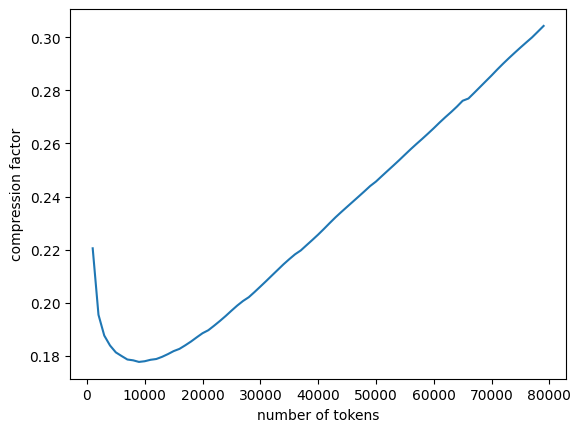

max compression vocab size: 9000


In [13]:
from matplotlib import pyplot as plt
Ns = NLV[:,0]
Ls = NLV[:,1]
Vs = NLV[:,2]

plt.plot(Ns,(Ls+Vs)/len(e))
plt.xlabel('number of tokens')
plt.ylabel('compression factor')

plt.show()

print('max compression vocab size:',Ns[np.argmin(Ls+Vs)])

In [14]:
# get token occurrence rate for best tokenizer
sp = spm.SentencePieceProcessor(
    model_file='sentencepiece/ecoli_7000.model')

toks = sp.encode_as_pieces(e)

tokcounts = Counter(toks).most_common()
tokcounts[:30]

[('c', 12460),
 ('ctgctg', 1296),
 ('gcg', 1168),
 ('cgc', 1060),
 ('acgctg', 994),
 ('ttt', 975),
 ('aac', 936),
 ('gtt', 913),
 ('catcag', 907),
 ('aaagcc', 907),
 ('cgcttt', 898),
 ('ggcgat', 867),
 ('aaa', 863),
 ('attgcc', 849),
 ('ctggcg', 846),
 ('aaagcg', 843),
 ('aaacag', 832),
 ('cag', 818),
 ('ttc', 802),
 ('gttgat', 790),
 ('cagcaa', 779),
 ('ctg', 778),
 ('ttgcag', 762),
 ('gaa', 756),
 ('ctgcgc', 755),
 ('gatatc', 744),
 ('cagttc', 738),
 ('ggcttt', 738),
 ('cagcag', 724),
 ('atg', 721)]

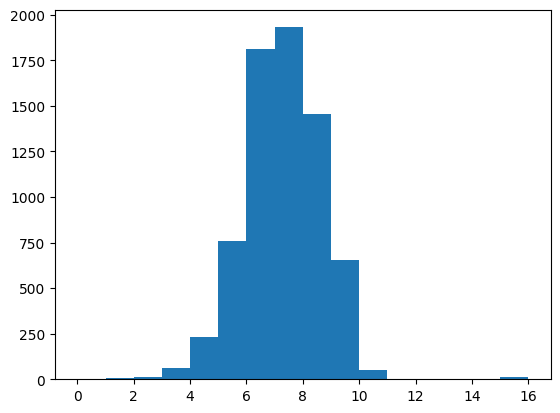

In [15]:
# token length distribution
plt.hist([len(t[0]) for t in tokcounts],
        bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
plt.show()

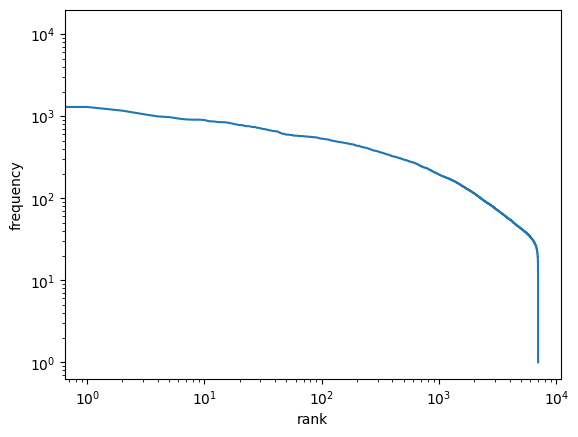

In [16]:
# plot rank-frequency curve
TC = [t[1] for t in tokcounts]
      #if len(t[0])==2]#[10:-1000]
plt.plot(np.arange(0,len(TC),1),TC)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

In [18]:
# get N,T tuples for each tokenizer.
# N: vocab size
# T: token counts

NT=[]
models = glob.glob('sentencepiece/ecoli_*.model')
for m in tqdm(models):
    N = int(m.split('_')[1].replace('.model',''))
    sp = spm.SentencePieceProcessor(model_file=m)
    toks = sp.encode_as_pieces(e)
    tokcounts = Counter(toks).most_common()


    NT.append((N,tokcounts))
    
NT = [NT[i] for i in np.argsort([n for n,t in NT])]

100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


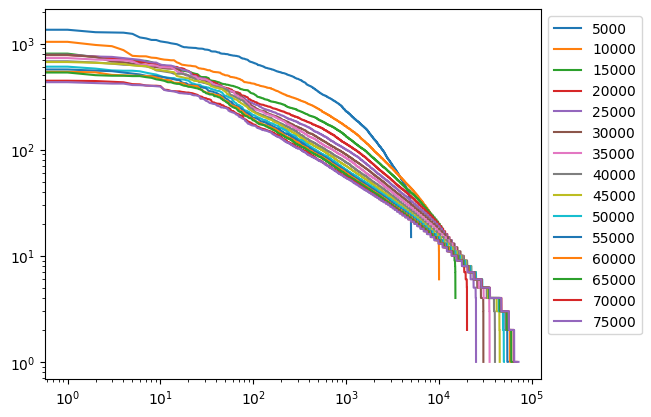

In [19]:
# plot rank-freqency curves for different tokenizers
for n,t in NT:
    if n%5000==0 and n<400000:
        plt.plot([c/t[1][1]**0 for _,c in t[1:-1]],label=n)

plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()